In [1]:
import os
import datetime
import torch
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import wandb
import sys
import matplotlib.pyplot as plt
import pickle

# from RMDT_model.RMDT import mem_transformer_v2

import os
import sys
sys.path.append("../../")

from VizDoom.VizDoom_src.utils.get_vizdoom_dataset import get_dataset


libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS


# Load VizDoom-Two-Colors data

In [2]:
# train_pickle_file = 'VizDoom/VizDoom_data/train_VizDoom_Two_Colors_Column_disappear_delay_45_no_walls_agent_p1_01.pickle'
val_pickle_file = '../../VizDoom/VizDoom_data/val_VizDoom_Two_Colors_Column_disappear_delay_45_no_walls_agent_p1_01.pickle'

# DATA2_train = []
DATA2_val = []

# with open(train_pickle_file, 'rb') as f:
#     while True:
#         try:
#             data = pickle.load(f)
#             DATA2_train.append(data)
#         except EOFError:
#             break
            
with open(val_pickle_file, 'rb') as f:
    while True:
        try:
            data = pickle.load(f)
            DATA2_val.append(data)
        except EOFError:
            break
            
# DATA_train = {}
DATA_val = {}

# for key in tqdm(DATA2_train[0].keys()):
#     DATA_train[key] = [d[key] for d in DATA2_train]
    
for key in tqdm(DATA2_val[0].keys()):
    DATA_val[key] = [d[key] for d in DATA2_val]

100%|██████████| 5/5 [00:00<00:00, 19765.81it/s]


In [3]:
print(DATA_val.keys())
# print(len(DATA_train['obs']))
print(len(DATA_val['obs']))

dict_keys(['obs', 'action', 'reward', 'done', 'is_red'])
256


In [4]:
DATA_val['reward'][31]

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 1.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 1.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.

In [5]:
# 
# TODO: write code to calculate mean and std for the whole dataset (current code isn't correct)

In [171]:
from torch.utils.data import random_split, DataLoader
val_dataset = get_dataset(DATA_val, gamma=1.0, max_length=3*30, normalize=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [172]:
def batch_mean_and_std(loader):
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _, _, _, _, _ in loader:
        b, l, c, h, w = images.shape
        images = images.reshape(-1, c, h, w)
        nb_pixels = b * l* h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        

    return mean, std
  
mean, std = batch_mean_and_std(val_dataloader)
print("mean and std:", mean, std)

mean and std: 
 tensor([13.5173, 19.6073, 14.7196]) tensor([16.2992, 20.0957, 10.2147])


In [173]:
traj = next(iter(val_dataloader))[0]
traj.shape

torch.Size([64, 90, 3, 64, 112])

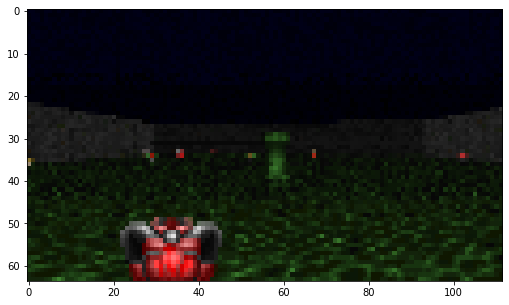

In [138]:
plt.figure(figsize=(10,5))
plt.imshow(traj[14][20].permute(1,2,0)/255.)
plt.show()

In [139]:
def z_normalize(data, mean, std):
    """_summary_

    traj_norm.shape = torch.Size([5760, 3, 64, 112])
    """
    return (data - mean[None, :, None, None]) / std[None, :, None, None]


def inverse_z_normalize(data, mean, std):
    return data * std[None, :, None, None] + mean[None, :, None, None]

In [140]:
b, l, c, h, w = traj.shape
traj_norm = traj.reshape(b*l, c, h, w)
traj_norm = z_normalize(traj_norm, mean, std)
traj_norm = traj_norm.reshape(b, l, c, h, w)

In [141]:
restored_traj = traj_norm.reshape(b*l, c, h, w)
restored_traj = inverse_z_normalize(restored_traj, mean, std)
restored_traj = restored_traj.reshape(b, l, c, h, w)

In [179]:
import time
t1 = time.time()
time.sleep(0.5)
print(time.time() - t1)

0.5009033679962158


In [8]:
from random import sample
sample(range(0,5), 3)

[1, 3, 4]

In [40]:
test = torch.tensor([[[1, 1, 1],
             [2,2,2],
             [3,3,3]],

             [[6, 6, 6],
             [7,7,7],
             [8,8,8]]], dtype=float)

std = torch.std(test, dim=[0, 1])
mean = torch.mean(test, dim=[0, 1])

In [41]:
test1 =  (test-mean)/std#(test - mean[None, :, None]) / std[None, :, None]
test2 =  (test - mean[None, :, None]) / std[None, :, None]

In [11]:
test1 - test2

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], dtype=torch.float64)

In [12]:
# a = 0``
# b = 1
# if a == 0 \
#     and b == 1:
#     print("rofl")